# Generating synthetic data sets of a river bed column forced by monoperiodic river and aquifer temperature signals

2024 developped by Nicolas Flipo from demo_gen_test.ipynb created by Guillaume de Rochefort during MOLONARI 2022 

The object of this demo is to present a class responsible for generating a simulation of pressure and temperature sensor data in cases where data from the CAPTEUR project is not available. Based on the `synthetic_MOLONARI` class in `synthetic_MOLONARI.py`.

We will show the `synthetic_MOLONARI` object which allows generating purely periodic datasets with the possibility of Gaussian noise. We will illustrate the interaction of `synthetic_MOLONARI` with the `Column` class and the `layer` class.

The other demo file `demo_val_direct.ipynb` highlights a more global use of the classes from `synthetic_MOLONARI.py` and `val_analy.py`.


In [17]:
# démo time_series
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

## 1. Signal Parameterization
The signals are purely periodic, and it is necessary to choose the amplitude, period, and mean value of the river temperature, aquifer temperature, and pressure signals (boundary conditions). The T1, T2, T3 sensors in the shaft are only generated using the direct model.

A possible improvement for this class is to generate multi-periodic signals similar to the parameter lists of the layer, where a list of parameters for the different desired frequencies (diurnal, monthly, annual, etc.) would be provided.

In [18]:
# l'utilisateur saisit ses paramètres d'émulation de mesure
"""Fenêtre temporelle"""
# le format demandé est celui-ci : (y,m,d,h,mn,s) compatible avec la librairie datetime
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*NSECINMIN # pas de temps en (s) # A AMELIORER AVEC UN CONVERTISSEUR AUTOMATIQUE D'UNITES

"""Conditions limites"""
# Température de la rivière
zeroT = 0
zeroT += ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 14 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.5 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4

"""Bruit de mesure"""
sigma_meas_P = 0.001
sigma_meas_T = 0.1

print("dt={0:.1f}s".format(dt))

dt=900.0s


## 2 Instantiating the objects `synthetic_MOLONARI` and `Column`
The generated object will have default values, and a series of methods must be used to update its essential parameters. In the initialisation of Time Series, the 3 intermediate temperature sensors T1, T2, T3, are initialized with a linear interpolation between Triv and Taq weighted by the distance from the sensor. Those values initialize the soil Column in a second step. For Time Series dH = Hriv-Haq

Initializing time series of synthetic_MOLONARI
param_time_dates: [(2011, 8, 1), (2011, 8, 31, 23, 59, 59), 900]
param_dH_signal: [0, -9999, 0.5]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
[datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.tim

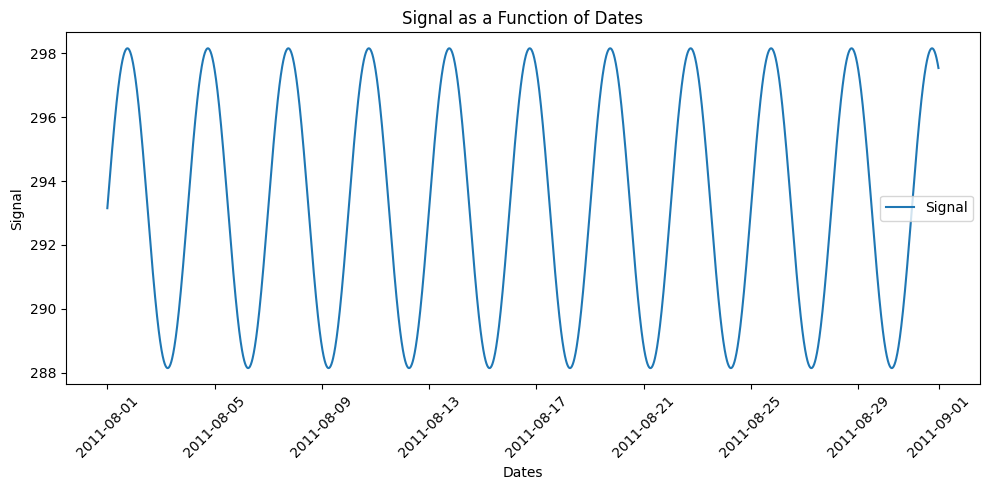

[datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.

In [19]:
"""Instanciation de l'objet Time_series"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)

# print("Checking params synthetic_MOLONARI")
# print("param_time_dates:", emu_observ_test_user1._param_dates)
# print("param_dH_signal:", emu_observ_test_user1._param_dH)
# print("param_T_riv_signal:", emu_observ_test_user1._param_T_riv)
# print("param_T_aq_signal:", emu_observ_test_user1._param_T_aq)
# print("sigma_meas_P:", emu_observ_test_user1._sigma_P)
# print("sigma_meas_T:", emu_observ_test_user1._sigma_T)


print(f"dH : {emu_observ_test_user1._molonariP_data}")
print(f"Tshaft : {emu_observ_test_user1._T_Shaft_measures}")

In [ ]:
# l'utilisateur génère un dictionnaire avec les données importantes de la colonne
name ="Couche en sable"
zLow = Zbottom
moinslog10IntrinK = 11
n = 0.1
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6
q = 5e-6

# modèle une couche
layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs, q)])

print(f"Layers list: {layers_list}")
nbcells = 85
# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._T_Shaft_measures,
    "nb_cells" : nbcells,
    "sigma_meas_P": 0.01, #float
    "sigma_meas_T": 0.1, #float
}
col = Column.from_dict(col_dict,verbose=True)

Layers list: [Couche en sable : ends at 0.4 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0, q=1e-07)]
Column created with success
Number of time steps: 2976
Time step in days: 0.01041316644265233
T_riv: [293.16711111 293.21888458 293.39598539 ... 297.46926468 297.53328728
 297.62852291]
T_aq: [287.18843909 287.21908965 287.28066704 ... 287.20362481 287.15629624
 287.06425456]
dH : [0.50017799 0.50084325 0.49876566 ... 0.49982878 0.50150924 0.49975379]
list of dates   : [datetime.datetime(2011, 8, 1, 0, 0), datetime.datetime(2011, 8, 1, 0, 15), datetime.datetime(2011, 8, 1, 0, 30), datetime.datetime(2011, 8, 1, 0, 45), datetime.datetime(2011, 8, 1, 1, 0), datetime.datetime(2011, 8, 1, 1, 15), datetime.datetime(2011, 8, 1, 1, 30), datetime.datetime(2011, 8, 1, 1, 45), datetime.datetime(2011, 8, 1, 2, 0), datetime.datetime(2011, 8, 1, 2, 15), datetime.datetime(2011, 8, 1, 2, 30), datetime.datetime(2011, 8, 1, 2, 45), datetime.datetime(2011, 8, 1, 3, 0), datetime.

## 3 Generating temperature in the river bed

We use the [_measures_column_one_layer(col, layers_list)] method, which updates the measurements for T1, T2 and T3 at each point in time with the direct model pyheatmy. The sensor time series are then perturbated with a gaussian noise in the Time series object. We display the temperature simulated at sensors.

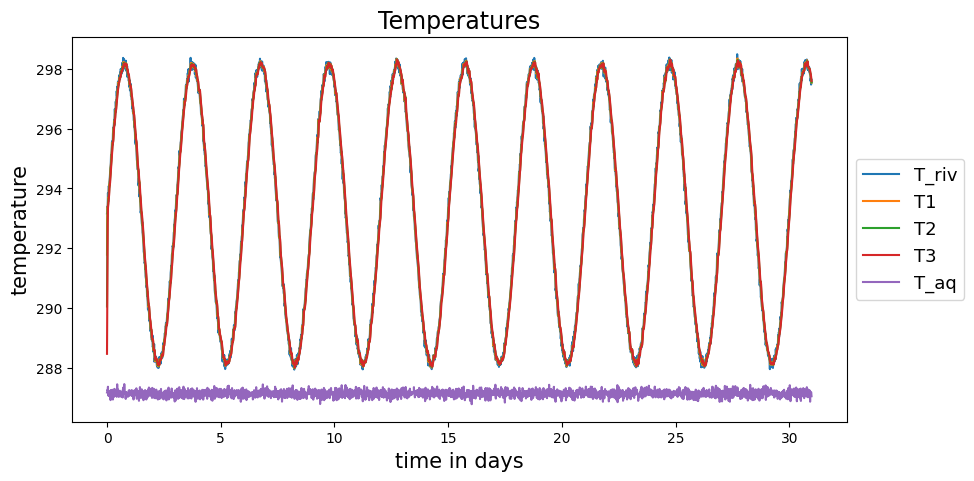

In [21]:
# print(emu_observ_test_user1._T_Shaft)
emu_observ_test_user1._measures_column_one_layer(col, layers_list)
#emu_observ_test_user1._plot_molonariT_data()
col.plot_temperature_at_sensors(verbose=False)

The simulated temperatures with pyheatmy are compared to the initial values of the Shaft which were interpolated. Without surprise, they are very different for an advective configuration (high k value)

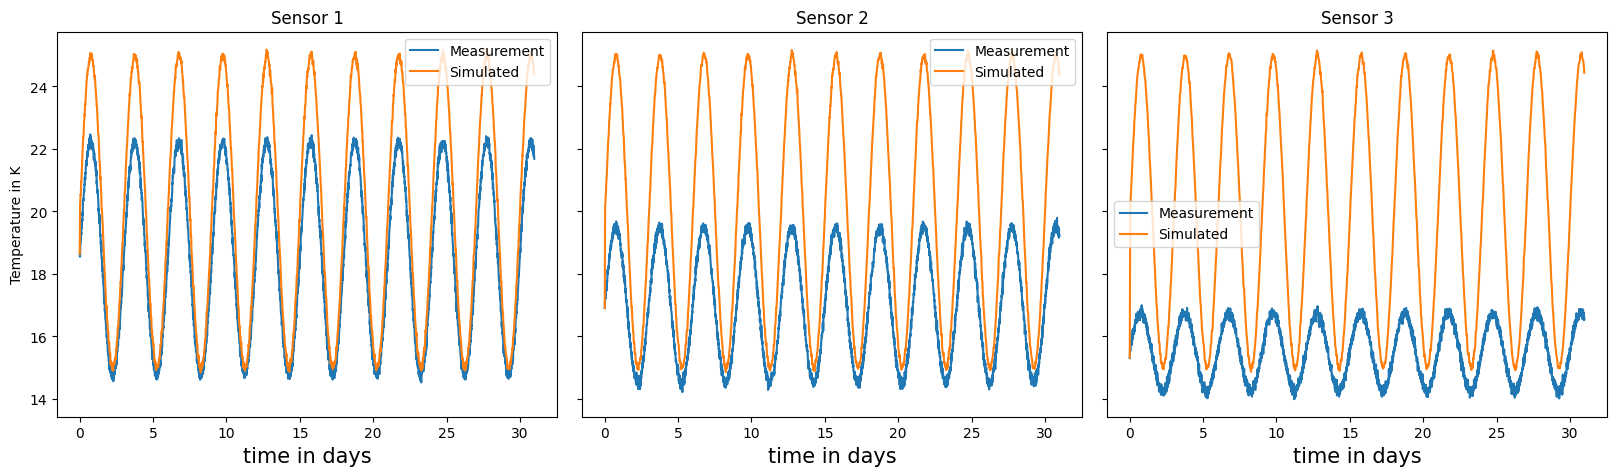

In [22]:
col.plot_compare_temperatures_sensors()

Here are temperature profiles simulated by pyheatmy

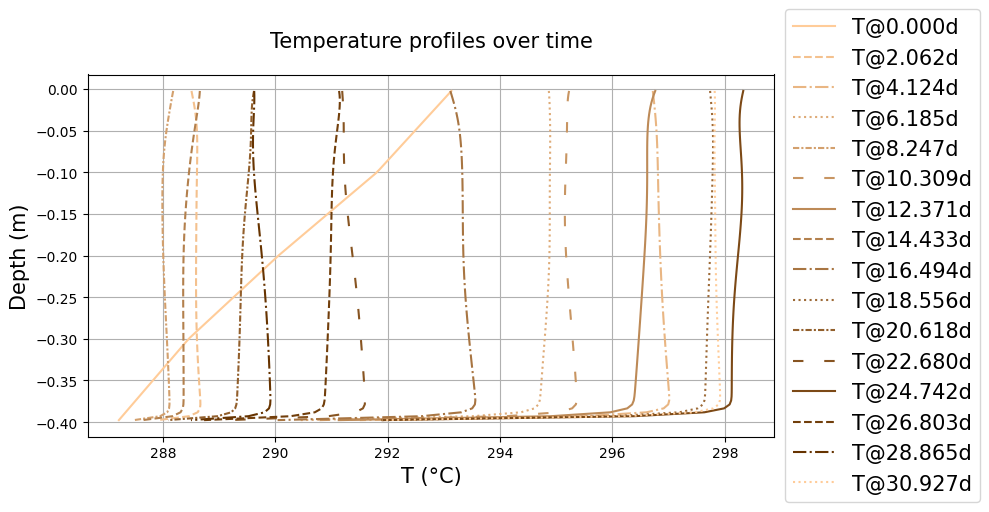

In [23]:
nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

Now creating a new column created with the generated case study

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0, q = 1e-07
Solving the flow with intrinsec permeability 1e-11, and permeability 9.810000000000001e-05
Done.


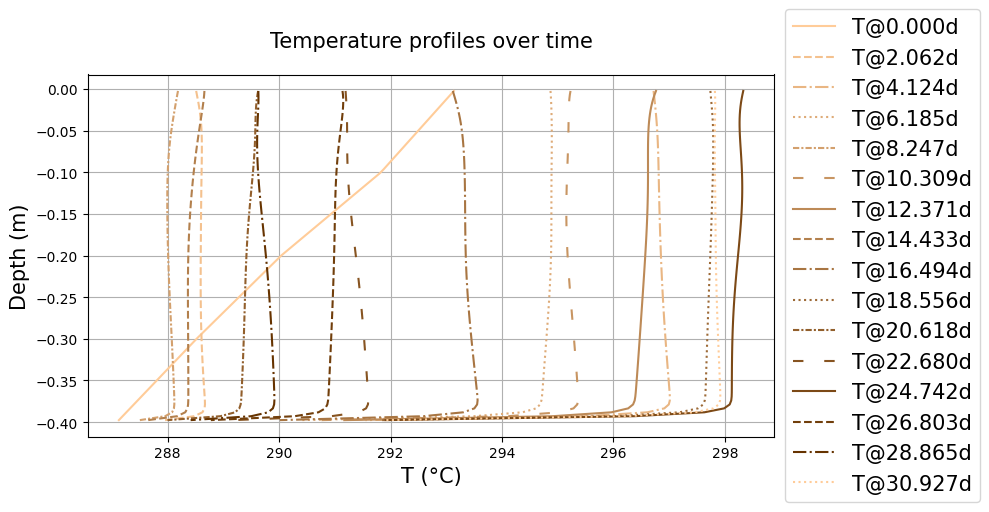

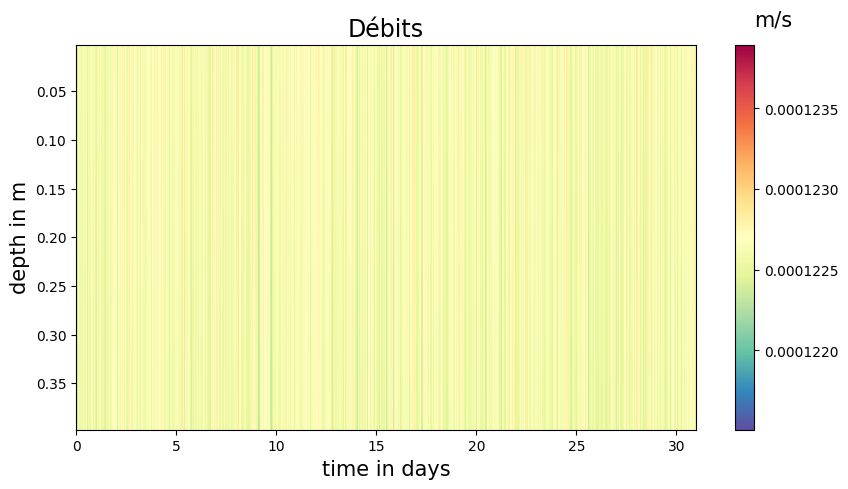

RMSE at sensor 0 : 0.09955097667903207
RMSE at sensor 1 : 0.1025935218771273
RMSE at sensor 2 : 0.09976292389950946
Total RMSE : 0.10064536530789864
Plotting Température in column. time series have nrecords =  2976
Creating /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_P_measures.csv
Creating /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_T_measures.csv
Creating /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_info.csv
File /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_P_measures.csv closed successfully.
File /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_T_measures.csv closed successfully.
File /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualPoint/VirtualPoint_info.csv closed successfully.
Creating /Users/omblinebrunet/OUTPUT_MOLONARI1D/generated_data/VirtualLabo/pressure_sensors/Pvirtual.csv
Printing Sensor f

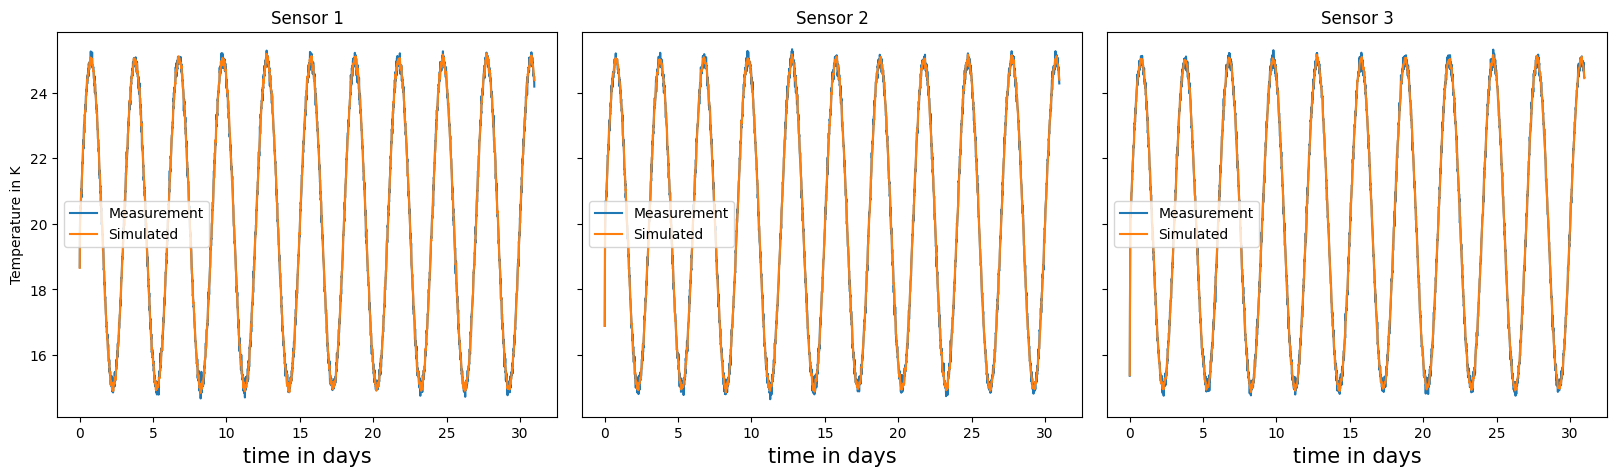

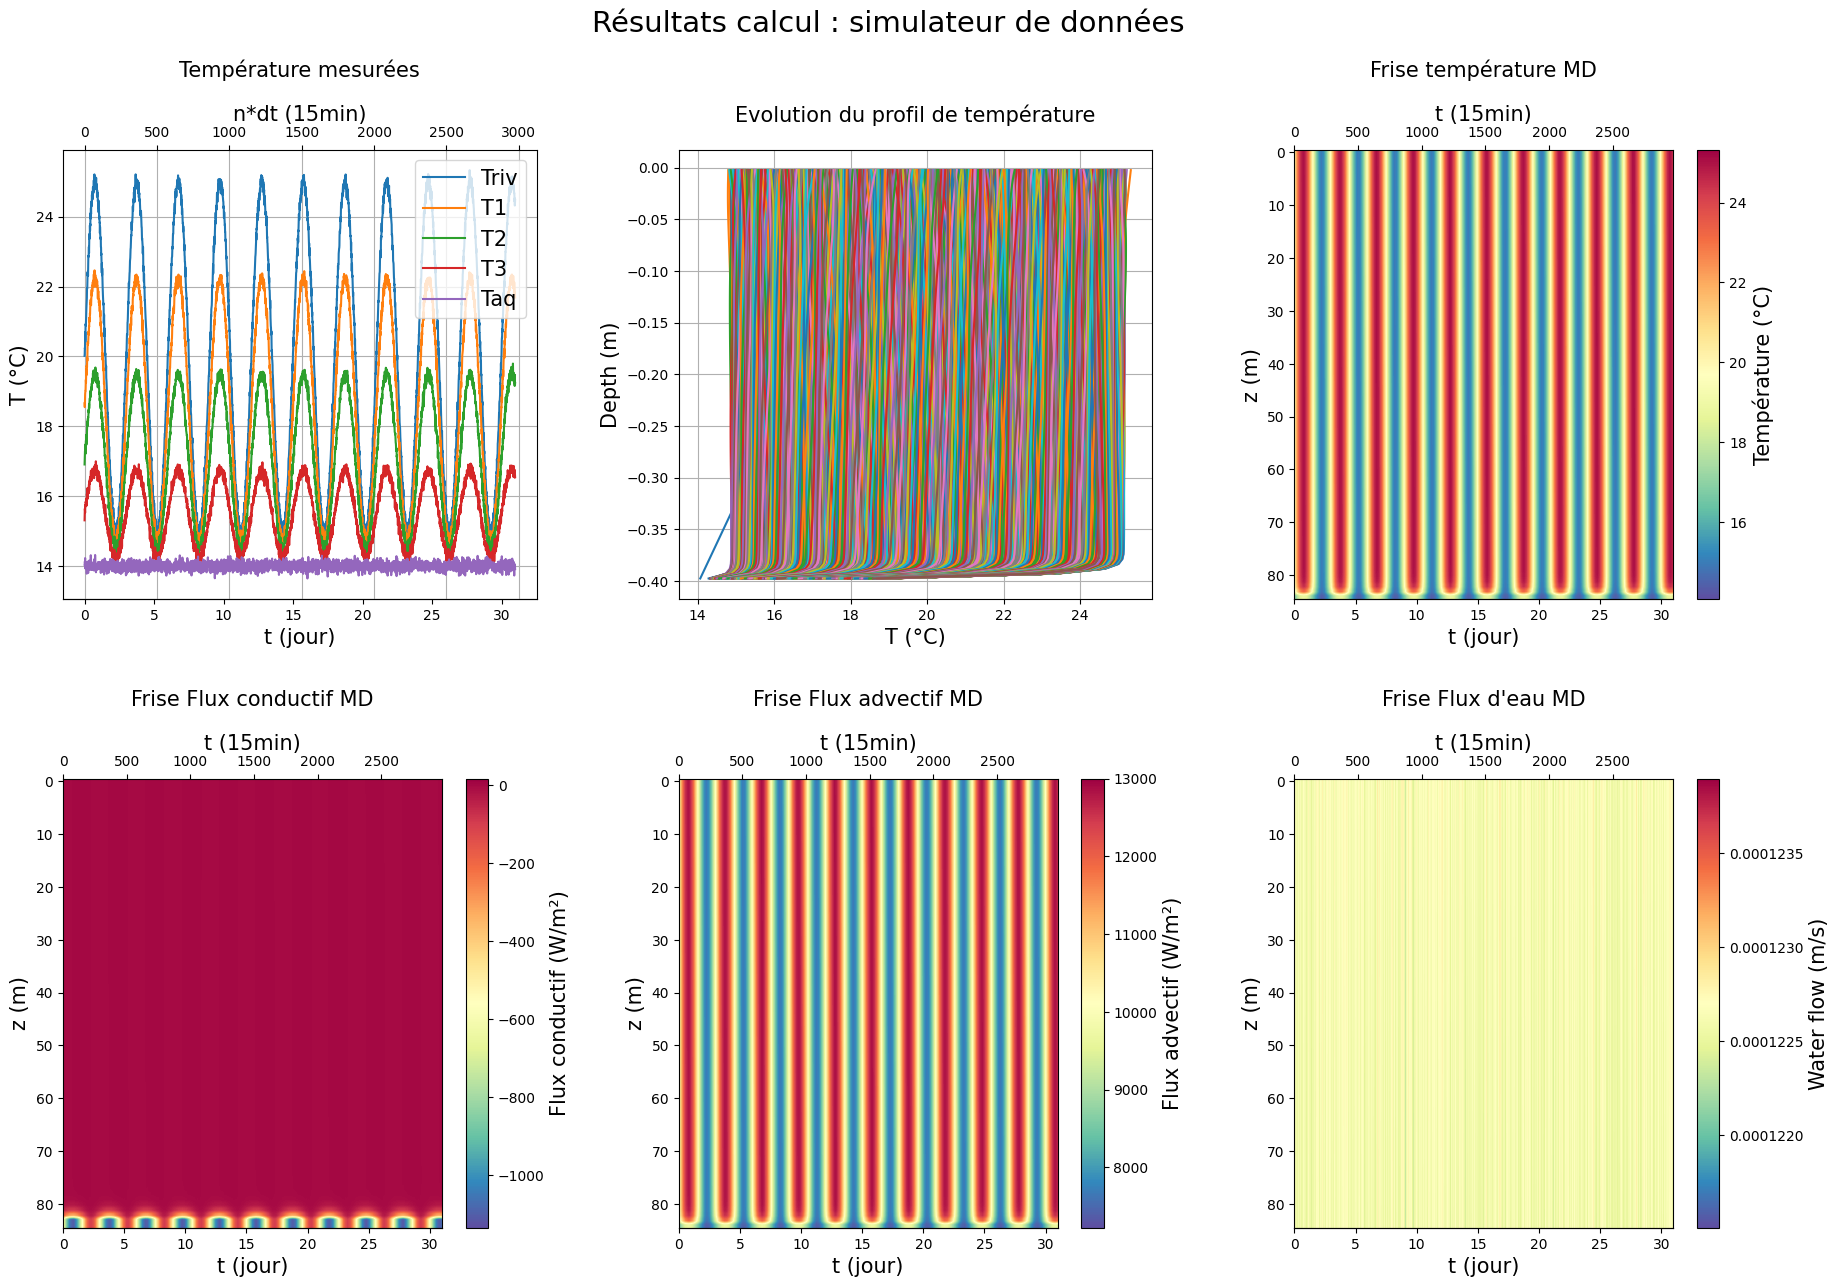

In [24]:
# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
newCol_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "nb_cells" : nbcells,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}
newCol = Column.from_dict(newCol_dict)
newCol.compute_solve_transi(layers_list,verbose=True)

nt = len(col._temperatures[0,:])
dplot=15
newCol.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
newCol.plot_it_Zt(flows,title,unitLeg,1.04,2)

newCol.print_RMSE_at_sensor()
newCol.plot_compare_temperatures_sensors()
col.plot_CALC_results()
newCol.print_in_file_processed_MOLONARI_dataset(zeroT=0)

# Multilayered riverbed

In [25]:
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*60 # pas de temps en (s)

T_riv_amp = 2
T_riv_offset = 20
P_T_riv = 72*4*dt

T_aq_amp = 0
T_aq_offset = 14
P_T_aq = 9999 # à mettre dans le init

dH_amp = 0
dH_offset = 1.
P_dh = -9999 #14*24*4*dt

depth_sensors = [.1, .15, .25, .3, .4] # on a mis 5 capteurs dans le shaft au lieu de 4 pour montrer que le code s'adapte

In [26]:
time_series_dict_user4 = {
    "offset" : 0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": 0.05,
    "sigma_meas_T": 0.1, #float
}

Initializing time series of synthetic_MOLONARI
param_time_dates: [(2011, 8, 1), (2011, 8, 31, 23, 59, 59), 900]
param_dH_signal: [0, -9999, 1.0]
param_T_riv_signal: [2, 259200, 20]
param_T_aq_signal: [0, 9999, 14]
sigma_meas_P: 0.05
sigma_meas_T: 0.1
[datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(sec

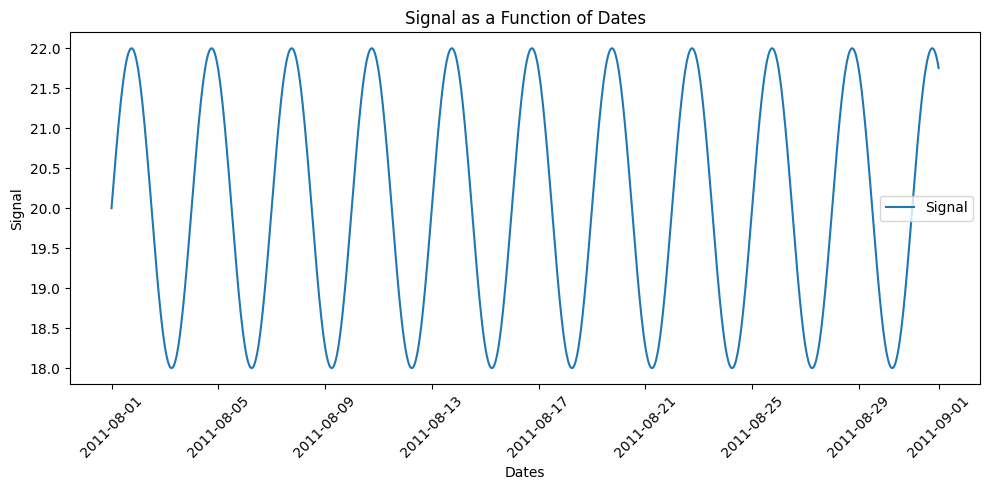

[datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.timedelta(seconds=900), datetime.

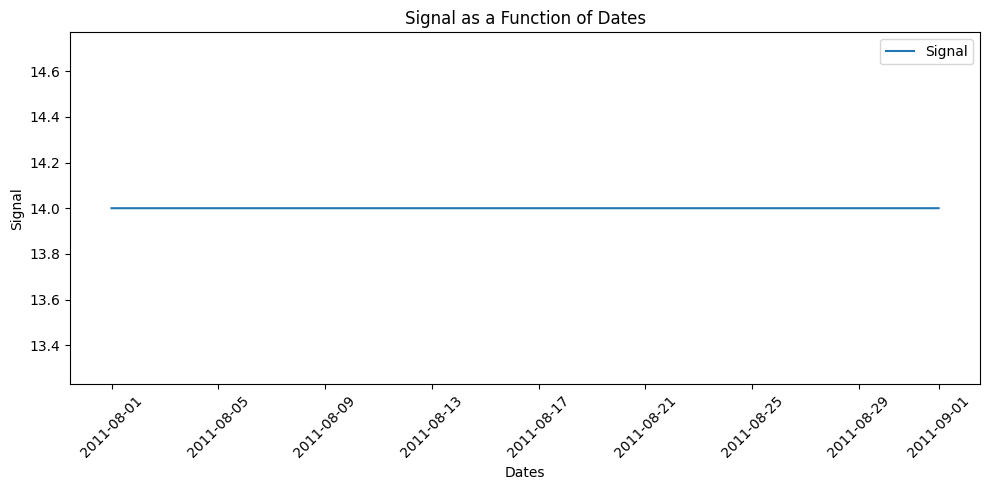

Generating Shaft with 5 sensors
5 sensors in the shaft
Temperature of Sensor 0 : [18.5        18.53272233 18.56542908 ... 19.84530911 19.83051625
 19.81509013]
Temperature of Sensor 1 : [17.75       17.77726861 17.80452423 ... 18.87109093 18.85876354
 18.84590844]
Temperature of Sensor 2 : [16.25       16.26636116 16.28271454 ... 16.92265456 16.91525812
 16.90754507]
Temperature of Sensor 3 : [15.5        15.51090744 15.52180969 ... 15.94843637 15.94350542
 15.93836338]
Temperature of Sensor 4 : [14. 14. 14. ... 14. 14. 14.]


In [27]:
emu_observ_test_user4 = synthetic_MOLONARI.from_dict(time_series_dict_user4)
# emu_observ_test_user4._generate_all_series()

In [28]:
# l'utilisateur génère un dictionnaire avec les données importantes de la colonne
name = ["gravier","Couche en sable"]
zLow_multilayer = [.2,.4]
moinslog10IntrinK_multilayer = [14,10]
n_multilayer = [.4,.1]
lambda_s_multilayer = [2,2] 
rhos_cs_multilayer = [4e6,4e6]
q_multilayer = [0,0]

# on utilise les mesures générées précédemment
col_dict4 = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user4._molonariP_data,
    "T_measures": emu_observ_test_user4._T_Shaft_measures,
    "nb_cells" : nbcells,
    "sigma_meas_P": emu_observ_test_user4._sigma_P, #float
    "sigma_meas_T": emu_observ_test_user4._sigma_T, #float
}

col4 = Column.from_dict(col_dict4)

# modèle une couche
layers_list4= layersListCreator([(name[i], zLow_multilayer[i], moinslog10IntrinK_multilayer[i], n_multilayer[i], lambda_s_multilayer[i], rhos_cs_multilayer[i], q_multilayer[i]) for i in range(len(name))])

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:40: RuntimeWarning: overflow encountered in exp
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))


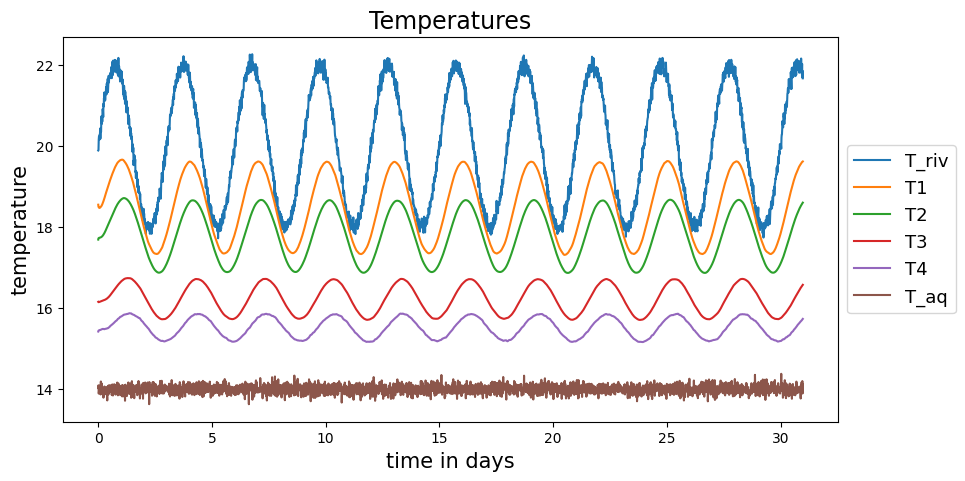

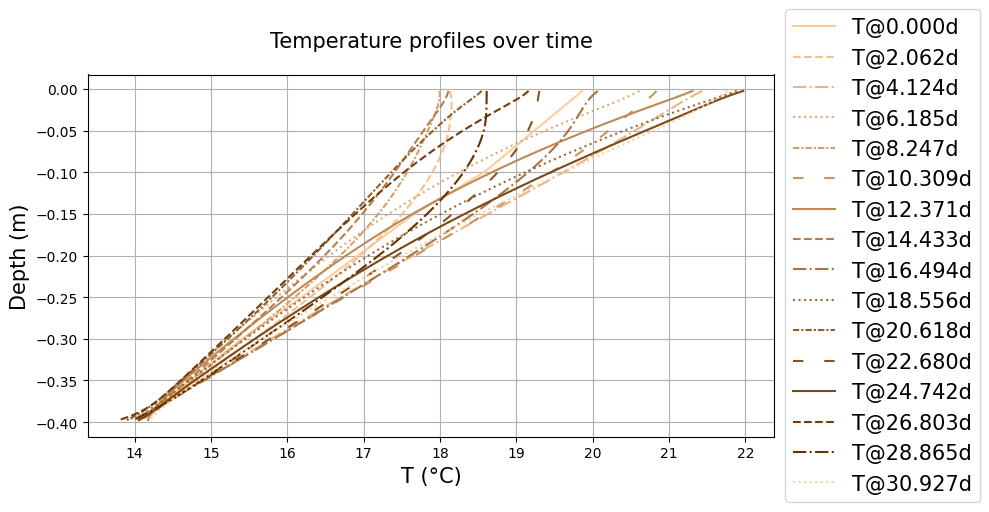

In [29]:
emu_observ_test_user4._measures_column_one_layer(col4, layers_list4)
col4.plot_temperature_at_sensors(verbose=False)
# col4.plot_compare_temperatures_sensors()
nt = len(col4._temperatures[0,:])
dplot=15
col4.plot_temperatures_umbrella(round(nt/dplot))


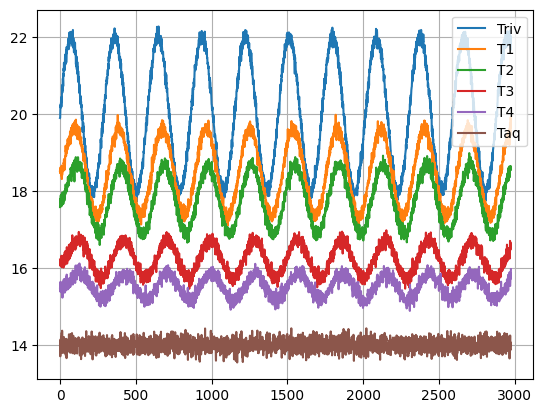

In [30]:
# les sorties des différents capteurs après passage dans le modèle direct
nt = 3000
plt.plot(emu_observ_test_user4._T_riv_perturb[:nt], label="Triv")
n_sens = len(emu_observ_test_user4._T_Shaft_perturb[0])
for i in range(n_sens-1):
    plt.plot(emu_observ_test_user4._T_Shaft_perturb[:nt,i], label="T{}".format(i+1))
plt.plot(emu_observ_test_user4._T_Shaft_perturb[:nt,n_sens-1], label="Taq")
plt.legend()
plt.grid()

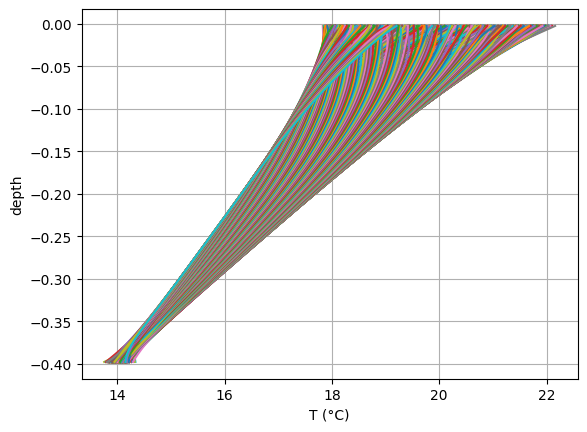

In [31]:
nt = len(col4._temperatures[0,:])
for i in range(1000,2000):
    plt.plot(col4._temperatures[:,i], -col._z_solve)
plt.ylabel("depth")
plt.xlabel("T (°C)")
plt.grid()
#plt.xlim(282,286)

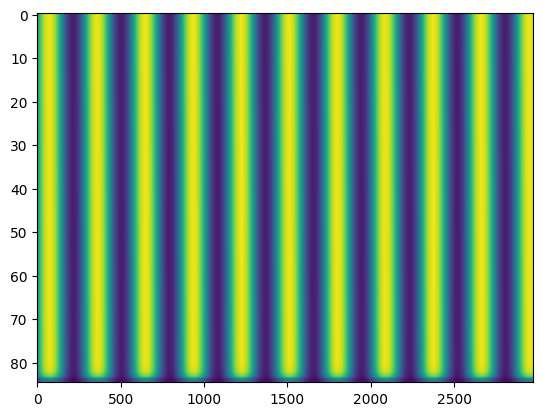

In [32]:
plt.imshow(col._temperatures[:,:], aspect='auto')

Unfinished, now need to rerun a column with the proper sensor records from the first simulation + perturbation that are in Time Series See final step of #3 of the Monolayer case